In [2]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=2f365b2a06ecdbb1398b20b257bde2275f3cc8e94289041b0283f24df914541d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=460490da76f8a8107452b8c3ae20023056a9f9d17ac5c59889e27635ae81536b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: timm
    Found existing installatio

In [3]:
#%load_ext autoreload
#%autoreload 2
#%matplotlib inline
import random

import cv2
import torch

import torchvision
import numpy as np
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.datasets import VOCSegmentation

import sys
sys.path.append("../input/cvmade-hw7/")
import cvmade

USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    DEVICE="cuda"
    print("Use CUDA")
else:
    DEVICE="cpu"
    
# Параметры тренировки и визуализации.
TRAIN = True  # Если False, будут использоваться заранее посчитанные графики
              # вместо реальной тренировки (полезно для демонстрации на ноутбуках без GPU).

def set_figure_size(figsize=(8, 6), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

Use CUDA


## Что было добавлено мной:
1. get_mean_IoU
2. CropAugmenter и PespectiveAugmenter
3. Dice Loss

In [4]:
def get_mean_IoU(predicted, masks):
    predicted, masks = crop_images(predicted, masks)
    
    predicted = predicted.permute(0, 2, 3, 1).reshape(-1)
    masks = masks.reshape(-1)
        
    # use approximate value of intersection
    intersection = torch.sum(predicted * masks)
    return intersection / (torch.sum(predicted + masks) - intersection)

In [5]:
class CropAugmenter(object):
    def __init__(self, size=(400, 400)):
        self._size = size

    def __call__(self, image, mask):
        image = np.array(image) # PIL -> Numpy.
        mask = np.array(mask)
        
        h, w, c = image.shape
        assert c == 3
        
        x = 0
        if w > self._size[1]:
            x = random.randint(0, w - self._size[1] + 1)
        
        y = 0
        if h > self._size[0]:
            y = random.randint(0, h - self._size[0] + 1)        
        
        new_image = image[y : y + self._size[0], x : x + self._size[1]]
        new_mask = mask[y : y + self._size[0], x : x + self._size[1]]
        
        return new_image, new_mask
    
    
class PespectiveAugmenter(object):
    def __init__(self, distortion_scale=0.1):
        self._distortion_scale = distortion_scale

    def __call__(self, image, mask):
        image = np.array(image) # PIL -> Numpy.
        mask = np.array(mask)
        
        h, w, c = image.shape
        assert c == 3
        
        old_points = np.float32([[0, 0], [h, 0], [0, w], [h, w]])
        new_points = np.float32([[0, 0], [h, 0], [0, w], [h, w]])
        
        new_points[0][0] += np.random.uniform(-self._distortion_scale * h, self._distortion_scale * h)
        new_points[0][1] += np.random.uniform(-self._distortion_scale * w, self._distortion_scale * w)
        new_points[1][0] += np.random.uniform(-self._distortion_scale * h, self._distortion_scale * h)
        new_points[1][1] += np.random.uniform(-self._distortion_scale * w, self._distortion_scale * w)        
        new_points[2][0] += np.random.uniform(-self._distortion_scale * h, self._distortion_scale * h)
        new_points[2][1] += np.random.uniform(-self._distortion_scale * w, self._distortion_scale * w)
        new_points[3][0] += np.random.uniform(-self._distortion_scale * h, self._distortion_scale * h)
        new_points[3][1] += np.random.uniform(-self._distortion_scale * w, self._distortion_scale * w)        
        
        perspective_matrix = cv2.getPerspectiveTransform(old_points, new_points)

    
        new_image = cv2.warpPerspective(image, perspective_matrix, (h, w))
        new_mask = cv2.warpPerspective(mask, perspective_matrix, (h, w))
        
        return new_image, new_mask

In [6]:
class DiceLoss(torch.nn.Module):
    """Функция потерь для сегментации с несколькими классами."""
    def __init__(self):
        super().__init__()
        self._xent = torch.nn.CrossEntropyLoss()
        
    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
        b, c, h, w = predicted.shape
        if c == 1:
            raise ValueError("{} не подходит для бинарной классификации".format(type(self)))
            
        predicted = predicted.permute(0, 2, 3, 1).reshape(b * h * w, c)
        masks = masks.reshape(-1)
        
        intersection = sum(predicted == masks)
        loss = 1 - 2 * intersection / (len(predicted) + len(masks))
        
        return loss

#### Код с augmentations.py

Добавил threshold чтобы не всегда применялись аугментации

In [7]:
class AffineAugmenter(object):
    def __init__(self, min_scale=0.9, max_offset=0.1, rotate=True):
        self._min_scale = min_scale
        self._max_offset = max_offset
        self._rotate = rotate

    def __call__(self, image, mask):
        image = np.array(image)  # PIL -> Numpy.
        mask = np.array(mask)
        h, w, c = image.shape
        assert c == 3
        if self._rotate:
            angle = random.random() * np.pi / 2 - np.pi / 4
        else:
            angle = 0
        scale = self._min_scale + random.random() * (1 - self._min_scale)
        rotation = cv2.getRotationMatrix2D(((w // 2), (h // 2)), angle * 180 / np.pi, scale)
        x_offset = random.randint(-int(self._max_offset * w), int(self._max_offset * w))
        y_offset = random.randint(-int(self._max_offset * h), int(self._max_offset * h))
        rotation[:, 2] += [x_offset, y_offset]
        new_image = cv2.warpAffine(image, rotation, (w, h), borderValue=(128, 128, 128))
        new_mask = cv2.warpAffine(mask, rotation, (w, h), borderValue=(0, 0, 0), flags=cv2.INTER_NEAREST)
        return new_image, new_mask  # Numpy -> PIL.


class BrightnessContrastAugmenter(object):
    def __init__(self, brightness=0.3, contrast=0.3):
        self._brightness = brightness
        self._contrast = contrast

    def __call__(self, image, mask):
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        brightness = 2 * (random.random() - 0.5) * self._brightness
        contrast = 1 + 2 * (random.random() - 0.5) * self._contrast
        new_image = image.astype(np.float16)
        new_image += 255 * brightness
        new_image = (new_image - 128) * contrast + 128
        return new_image.clip(0, 255).astype(np.uint8), mask  # Numpy -> PIL.


class BlurAugmenter(object):
    def __init__(self, max_kernel=5):
        self._max_kernel = max_kernel

    def __call__(self, image, mask):
        kernel = random.randint(0, self._max_kernel // 2) * 2 + 1
        if kernel == 1:
            return image, mask
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        new_image = cv2.GaussianBlur(image, (kernel, kernel), sigmaX=kernel / 2)
        return new_image.clip(0, 255).astype(np.uint8), mask  # Numpy -> PIL.
    
    
class FlipAugmenter(object):
    def __call__(self, image, mask):
        a = random.randint(0, 3)
        if a == 0:
            image = np.flip(image, axis=0)
            mask = np.flip(mask, axis=0)
        elif a == 1:
            image = np.flip(image, axis=0)
            mask = np.flip(mask, axis=0)
            image = np.flip(image, axis=1)
            mask = np.flip(mask, axis=1)
        elif a == 2:
            image = np.flip(image, axis=1)
            mask = np.flip(mask, axis=1)
        return image, mask


class RandomAugmentation(object):
    def __init__(self, *augmenters):
        self._augmenters = list(augmenters)

    def __call__(self, image, mask):
        if random.random() > 0.5:
            return random.choice(self._augmenters)(image, mask)
        return image, mask
        


#### Код с seminar.py

здесь я добавил в валидационный шаг логгирование mean IoU

In [8]:
import random
import numpy as np
import torch
import torchvision
import pytorch_lightning as pl
from torchvision.datasets import CIFAR10


class Module(pl.LightningModule):
    def __init__(self, model, loss_fn, optimizer_fn, trainset, testset,
                 lr_scheduler_fn=None,
                 batch_size=16):
        super().__init__()
        self._model = model
        self._optimizer_fn = optimizer_fn
        self._lr_scheduler_fn = lr_scheduler_fn
        self._dice_loss = loss_fn[0]()
        self._bce = loss_fn[1]()
        self._batch_size = batch_size
        self._trainset = trainset
        self._testset = testset
        
    def forward(self, input):
        return self._model(input)
    
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        x, y = batch
        logits = self._model(x)
        loss = self._dice_loss(logits, y) * 0.25 + self._bce(logits, y) * 0.75       
        self.logger.experiment.add_scalars("loss", 
                                           {"train": loss}, 
                                           global_step=self.global_step)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self._model(x)
        loss = self._dice_loss(logits, y) * 0.25 + self._bce(logits, y) * 0.75
        self.logger.experiment.add_scalars("loss", 
                                           {"val": loss}, 
                                           global_step=self.global_step)
        
        self.logger.experiment.add_scalars("mean_IoU", 
                                           {"val": get_mean_IoU(logits, y)}, 
                                           global_step=self.global_step)
        
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self._trainset, batch_size=self._batch_size, shuffle=True, drop_last=True, num_workers=4)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self._testset, batch_size=self._batch_size, shuffle=False, num_workers=4)

    def configure_optimizers(self):
        optimizer = self._optimizer_fn(self._model)
        scheduler = self._lr_scheduler_fn(optimizer)
        if scheduler:
            return [optimizer], [scheduler]
        else:
            return optimizer
    

def train_model(model, loss_fn, optimizer_fn, trainset, testset,
                lr_scheduler_fn=None,
                batch_size=4,
                eval_steps=250,
                num_epochs=1):
    model = Module(model, loss_fn, optimizer_fn, trainset, testset,
                   lr_scheduler_fn, batch_size)
    trainer = pl.Trainer(accelerator='cuda', max_epochs=num_epochs, val_check_interval=eval_steps)
    trainer.fit(model)


class CheckerError(Exception):
    pass


def check_ok():
    print("========")
    print("CHECK OK")

def check_conv1x1(layer_fn):
    layer = layer_fn(2, 5)
    if not isinstance(layer, torch.nn.Conv2d):
        raise CheckerError("conv1x1: неверные тип слоя")
    if layer.kernel_size != (1, 1):
        raise CheckerError("conv1x1: неверный размер свертки")
    if layer.in_channels != 2 or layer.out_channels != 5:
        raise CheckerError("conv1x1: неверное количество каналов")

def check_t_conv(layer_fn):
    layer = layer_fn(2, 5)
    if not isinstance(layer, torch.nn.ConvTranspose2d):
        raise CheckerError("transposed2x2: неверные тип слоя")
    if layer.kernel_size != (2, 2):
        raise CheckerError("transposed2x2: неверный размер свертки")
    if layer.stride != (2, 2):
        raise CheckerError("transposed2x2: неверный шаг")
    if layer.in_channels != 2 or layer.out_channels != 5:
        raise CheckerError("transposed2x2: неверное количество каналов")
        
def check_bce_loss(loss_class):
    loss_computer = loss_class()
    if not isinstance(loss_computer._bce, torch.nn.BCEWithLogitsLoss):
        raise CheckerError("Неверный класс функции потерь")
    def to_logits(probs):
        return np.log(probs) - np.log(1 - probs)
    logits = torch.from_numpy(to_logits(np.array([0.9, 0.2]))).reshape(2, 1, 1, 1).float()
    labels = torch.from_numpy(np.array([1, 0])).reshape(2, 1, 1).long()
    value = loss_computer(logits, labels).item()
    if abs(value + np.mean(np.log([0.9, 0.8]))) > 1e-3:
        raise CheckerError("Неверное значение функции потерь")

# Тренировка Unet на Pascal VOC.

## Подготовка данных

Мы будем использовать корпус Pascal VOC.

In [9]:
DATA_ROOT = "/kaggle/input/hw7-segmentation-models-and-pascalvoc/PascalVOC2012"
VOC_YEAR = "2012"
LABELS = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle",
          "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse",
          "motorbike", "person", "potted_plant", "sheep", "sofa", "train", "tv/monitor"]
MULTICLASS = False  # Если False, отделяем объекты от фона, иначе распознаем класс объектов.
NUM_CLASSES = len(LABELS) if MULTICLASS else 2
print("Number of classes:", NUM_CLASSES)

Number of classes: 2


Mask values: {0, 1, 255}


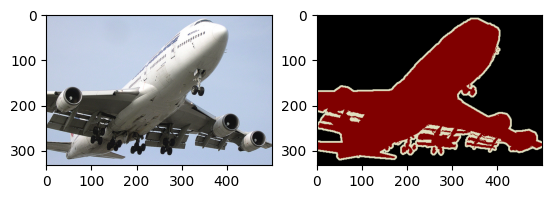

In [10]:
# Посмотрим на валидационную часть корпуса.
valset_raw = VOCSegmentation(DATA_ROOT, VOC_YEAR, "val", download=False)

image, mask = valset_raw[random.randint(0, len(valset_raw) - 1)]
print("Mask values:", set(np.array(mask).flatten().tolist()))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

Маска содержит номера классов для каждого пикселя. Имеется две специальные метки: 0 для фона и 255 для контура. Контур мы уберем.

In [11]:
for _ in range(5):
    i = random.randint(0, len(valset_raw) - 1)
    print("Image {:05d} size: {}".format(i, valset_raw[i][0].size))

Image 01174 size: (500, 375)
Image 01006 size: (500, 333)
Image 00321 size: (500, 375)
Image 01005 size: (500, 375)
Image 01076 size: (500, 433)


Заметим:
* Сеть U-Net способна обрабатывать изображения разных размеров, однако из изображений разного размера нельзя составить однородный тензор батча. Значит, изображения разного размера затруднят тренировку.

* Сеть U-Net является полностью сверточной сетью без паддинга, значит каждый нейрон видит лишь часть картинки и не зависит от положения на изображении и близости к границе.

* Область внимания каждого нейрона задается в пикселях. Значит, чем меньше изображение, тем больше информации о сцене получает каждый нейрон.

Мы будем приводить изображения к одному размеру масштабированием с сохранением пропорций.

При масштабировании изображений с сохранением пропорций и встравивании их в квадратные изображения, образуются пустые области. Пустые области будем заполнять зеркальными отражениями.

In [12]:
class Scaler(object):
    """Отмасштабировать изображения сохранив пропорции.
    
    Пустые места будут заполнены отражениями.

    Аргументы:
        image: Изображение в HWC формате.
        size: Требуемый размер, пара W, H.
    """
    def __init__(self, size):
        self._size = size
        self._padding = 0
    
    def set_padding(self, padding):
        self._padding = padding
        
    def __call__(self, image):
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        grayscale = (len(image.shape) == 2)
        if grayscale:
            image = image[..., None]
        rw, rh = self._size
        p = self._padding
        h, w, c = image.shape
        scale_x = rw / w
        scale_y = rh / h
        scale = min(scale_x, scale_y)
        sw = int(scale * w)
        sh = int(scale * h)
        offset_x = p + (rw - sw) // 2
        offset_y = p + (rh - sh) // 2
        # Используем zeros на случай маленьких изображений.
        result = np.zeros((rh + 2 * p, rw + 2 * p, c), dtype=image.dtype)
        cv2.resize(image, (sw, sh),
                   interpolation=cv2.INTER_NEAREST if grayscale else cv2.INTER_AREA,
                   dst=result[offset_y:offset_y + sh, offset_x:offset_x + sw])

        # Отразить.
        result[offset_y:offset_y + sh, :offset_x] = result[offset_y:offset_y + sh, offset_x:2 * offset_x][:, ::-1]
        offset_end = result.shape[1] - offset_x - sw
        result[offset_y:offset_y + sh, offset_x + sw:] = result[offset_y:offset_y + sh, sw + offset_x - offset_end:sw + offset_x][:, ::-1]
        
        result[:offset_y] = result[offset_y:2 * offset_y][::-1]
        offset_end = result.shape[0] - offset_y - sh
        result[offset_y + sh:] = result[sh + offset_y - offset_end:sh + offset_y][::-1]
        
        if grayscale:
            result = result[:, :, 0]
        return result

    
def remove_borders_inplace(mask):
    mask[mask == 255] = 0
    return mask
    

In [13]:
class VOCDataset(torch.utils.data.Dataset):
    """Обертка для стандартного класса, которая форматирует данные."""
    def __init__(self, root, year, image_size,
                 multiclass=MULTICLASS,
                 download=False, augment=False,
                 train=False, train_fraction=0.8,
                 padding=0):
        """Создать корпус.
        
        Аргументы:
            root: Путь до папки для хранения данных.
            year: 2007 или 2012.
            image_size: Ширина и высота изображений.
            download: Скачать корпус, если он не найден в папке.
            augment: Применить аугментации.
            train: Выделить train часть, иначе validation.
            train_fraction: Доля тренировочных примеров.
            padding: Добавить дополнительный зеркальынй паддинг к изображению.
        """
        self._dataset = VOCSegmentation(root, str(year), "trainval", download=download)
        self._image_size = np.array(image_size)
        self._multiclass = multiclass
        self._padding = padding
        
        ids = list(range(len(self._dataset)))
        random.seed(0)
        random.shuffle(ids)
        train_size = int(len(ids) * train_fraction)
        self._indices = ids[:train_size] if train else ids[train_size:]

        self._image_scaler = Scaler(image_size)
        self._mask_scaler = Scaler(image_size)
        if augment:
            self._augmenter = RandomAugmentation(AffineAugmenter(),
                                                 BrightnessContrastAugmenter(),
                                                 BlurAugmenter(),
                                                 FlipAugmenter(),
                                                 CropAugmenter(), 
                                                 PespectiveAugmenter(),
                                                )
        else:
            self._augmenter = lambda image, mask: (image, mask)
        
    @property
    def image_size(self):
        return self._image_size + self._padding * 2
    
    def set_padding(self, padding):
        self._padding = padding
        self._image_scaler.set_padding(padding)
        self._mask_scaler.set_padding(padding)
        
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, idx):
        image, mask = self._dataset[self._indices[idx]]
        image = np.asarray(image)
        mask = np.array(mask)
        remove_borders_inplace(mask)
        if not self._multiclass:
            mask[mask > 0] = 1
        image, mask = self._augmenter(image, mask)   
        image = self._image_scaler(image)
        mask = self._mask_scaler(mask)
        
        image, mask = self._augmenter(image, mask)   
        
        image = self._image_scaler(image)
        mask = self._mask_scaler(mask)
        
        image = cvmade.image.image_to_torch(image).float() - 0.5
        mask = cvmade.image.image_to_torch(mask[..., None]).long()[0]
        return image, mask

IMAGE_SIZE = 512  # В исходной статье U-Net применяется к изображениям размера 572.

# Корпус был загружен выше, download = False.
trainset = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                      multiclass=MULTICLASS, train=True)
valset = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                    multiclass=MULTICLASS, train=False)
print("Image size:", IMAGE_SIZE)
print("Train set size:", len(trainset))
print("Validation set size:", len(valset))

Image size: 512
Train set size: 2330
Validation set size: 583


Корпус очень маленький.
1. Мы будем учить сеть, состоящую только из сверток. У таких сетей относительно мало параметров и они могут обучаться на небольших корпусах.
2. Каждый пиксель - отдельная метка. Количество пикселей в корпусе огромно, в этом смысле корпус большой.
3. Добавим аугментации

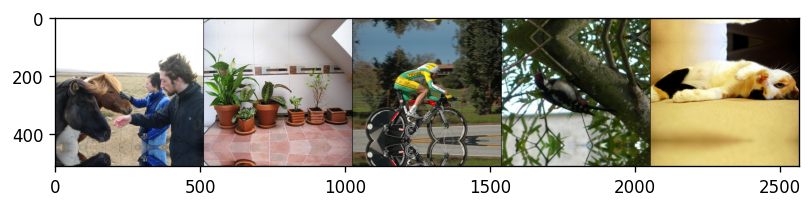

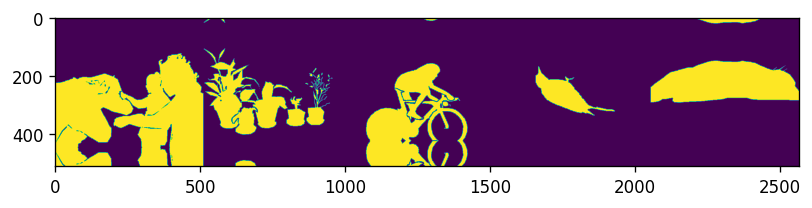

In [14]:
def show_dataset(dataset):
    images = []
    masks = []
    for _ in range(5):
        i = random.randint(0, len(valset) - 1)
        if len(images):
            separator = np.zeros((dataset.image_size[0], 2, 3), dtype=np.uint8)
            images.append(separator)
            masks.append(separator[:, :, 0])
        image, mask = dataset[i]
        images.append(cvmade.image.image_to_numpy(image))
        masks.append(cvmade.image.image_to_numpy(mask[None, ...])[..., 0])

    %matplotlib inline
    set_figure_size()
    plt.imshow(np.concatenate(images, axis=1))
    plt.show()
    set_figure_size()
    plt.imshow(np.concatenate(masks, axis=1))
    plt.show()
    
valset.set_padding(0)
show_dataset(trainset)

## Создание модели

Создадим сеть вида U-Net ( https://arxiv.org/pdf/1505.04597.pdf ).

In [15]:
def make_conv1x1(in_channels, out_channels):
    """Создать слой свертки 1x1."""
    
    layer = torch.nn.Conv2d(in_channels, out_channels, 1)
    return layer

def make_transposed_convolution2x2(in_channels, out_channels):
    """Создать транспонированную свертку (AKA deconvolution, upconvolution)."""
    
    # Обратите внимание на параметр output_padding. Поскольку stride в maxpooling
    # может давать один и тот же размер выхода для разных размеров входа, необходимо
    # указать такую добавку к размерности, чтобы получился тензор той же размерности,
    # что и в первой части сети.
    #
    # Поскольку у нас размер изображения всегда четный,
    # output_padding нужно выставить в 0.
    
    layer = torch.nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
    return layer

def make_conv3x3(in_channels, out_channels, bias=True):
    return torch.nn.Conv2d(in_channels, out_channels, 3, bias=bias)

def make_batchnorm(channels):
    return torch.nn.BatchNorm2d(channels)

def make_relu():
    return torch.nn.ReLU(inplace=True)

def make_maxpool2x2():
    return torch.nn.MaxPool2d(2)

check_conv1x1(make_conv1x1)
check_t_conv(make_transposed_convolution2x2)
check_ok()

CHECK OK


In [16]:
class ConvBlock(torch.nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            make_conv3x3(in_channels, out_channels, bias=False),
            make_batchnorm(out_channels),
            make_relu(),
            make_conv3x3(out_channels, out_channels, bias=False),
            make_batchnorm(out_channels),
            make_relu()
        )
        
class ResConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.main_path = torch.nn.Sequential(
            make_conv3x3(in_channels, out_channels, bias=False),
            make_batchnorm(out_channels),
            make_relu(),
            make_conv3x3(out_channels, out_channels, bias=False),
            make_batchnorm(out_channels)
        )
        self.residual_path = make_conv1x1(in_channels, out_channels)
        self.last_relu = make_relu()
        
    def forward(self, x):
        result = self.main_path(x)
        residual = self.residual_path(x)[:, :, 2:-2, 2:-2]
        result = self.last_relu(result + residual)
        return result

In [17]:
# Мы реализуем два класса. Down реализует преобразование между двумя max pooling,
# при этом начинается с max pooling. Первые две свертки сети в него не входят.
# Up реализует преобразование между двумя транспонированными свертками и начинает с
# транспонированной свертки. Последняя свертка сети в него не входит.
#
# Схема модели:
# input -> conv -> conv -> Down x 4 -> Up x 4 -> conv -> output.

class UNetDown(torch.nn.Sequential):
    """Часть сети между двумя max pooling, которая начинается с max pooling."""
    def __init__(self, in_channels, out_channels, block):
        layers = [
            make_maxpool2x2(),
            block(in_channels, out_channels)
        ]
        super().__init__(*layers)
     
    
class UNetUp(torch.nn.Module):
    """Часть сети между двумя транспонированными свертками, которая начинается с
    транспонированной свертки."""
    def __init__(self, in_channels, out_channels, block):
        super().__init__()
        self._transposed_convolution = make_transposed_convolution2x2(in_channels, out_channels)
        self._convolutions = block(out_channels * 2, out_channels)
    
    def forward(self, x_down, x_up):
        x_up = self._transposed_convolution(x_up)
        
        b_down, c_down, h_down, w_down = x_down.shape
        b_up, c_up, h_up, w_up = x_up.shape
        if (h_up > h_down) or (w_up > w_down):
            raise ValueError("Up tensor must be smaller than down tensor")
        offset = ((h_down - h_up) // 2, (w_down - w_up) // 2)
        x_down_cropped = x_down[:, :, offset[0]:offset[0] + h_up, offset[1]:offset[1] + w_up]
        
        x = torch.cat((x_down_cropped, x_up), axis=1)
        result = self._convolutions(x)
        return result


class UNet(torch.nn.Module):
    def __init__(self, num_classes, num_scales=4, base_filters=64, block=ConvBlock):
        """Создать U-Net сеть.
        
        Параметры:
            num_classes: Число классов на выходе. Для классификации объект/фон нужно два класса.
            num_scales: Число блоков U-Net сети, выполняющих изменение размера изображения.
            base_filters: Число фильтров на первом уровне сети.
        """
        super().__init__()
        self._input_convolutions = block(3, base_filters)
        
        layers = []
        filters = base_filters
        for i in range(num_scales):
            layers.append(UNetDown(filters, filters * 2, block))
            filters *= 2
        self._down_layers = torch.nn.Sequential(*layers)
        
        layers = []
        for i in range(num_scales):
            layers.append(UNetUp(filters, filters // 2, block))
            filters //= 2
        self._up_layers = torch.nn.Sequential(*layers)
        
        self._output_convolution = make_conv1x1(filters, num_classes)
        self.initialize_weights()

        # Оценим насколько сеть уменьшает изображение.
        self.eval()
        sample_input = torch.zeros((1, 3, 1000, 1000))
        if USE_CUDA:
            sample_input = sample_input.cuda()
            self.cuda()
        with torch.no_grad():
            sample_output = self(sample_input)
        self.padding = (sample_input.shape[-1] - sample_output.shape[-1]) // 2
        
    def forward(self, x):
        down_results = [self._input_convolutions(x)]
        for layer in self._down_layers:
            down_results.append(layer(down_results[-1]))
        x = down_results[-1]
        for i, layer in enumerate(self._up_layers):
            x = layer(down_results[-2 - i], x)
        x = self._output_convolution(x)
        return x
     
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
                torch.nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
        
def count_parameters(model):
    total = 0
    for p in model.parameters():
        total += np.prod(list(p.shape))
    return total

USE_RESIDUALS = True

unet = UNet(NUM_CLASSES if NUM_CLASSES > 2 else 1,
            num_scales=4,  # Число блоков U-Net сети, в статье 4.
            base_filters=64,  # Размер свертки на первом уровне, в статье 64.
            block=ResConvBlock if USE_RESIDUALS else ConvBlock)

print(unet)
print("Required padding: {}".format(unet.padding))
print("Total parameters: {}".format(count_parameters(unet)))

UNet(
  (_input_convolutions): ResConvBlock(
    (main_path): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (residual_path): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (last_relu): ReLU(inplace=True)
  )
  (_down_layers): Sequential(
    (0): UNetDown(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ResConvBlock(
        (main_path): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), 

## Обучение

Создадим класс для подсчета функции потерь - бинарной перекрестной энтропии.

In [18]:
def crop_images(predicted, masks_or_images):
    """Если выход больше или меньше чем исходное изображение,
    вырезать центральную часть из обоих, чтобы размеры совпадали.
    """
    if len(masks_or_images.shape) == 3:
        predicted, masks = crop_images(predicted, masks_or_images.unsqueeze(1))
        return predicted, masks[:, 0]
    images = masks_or_images
    if (len(predicted.shape) != 4) or (len(images.shape) != 4):
        raise ValueError("Expected tensors of shape BCHW")
    bi, ci, hi, wi = images.shape
    bp, cp, hp, wp = predicted.shape
    offset = (abs(hi - hp) // 2, abs(wi - wp) // 2)
    if hp < hi:
        images = images[:, :, offset[0]:offset[0] + hp]
    else:
        predicted = predicted[:, :, offset[0]:offset[0] + hi]
    if wp < wi:
        images = images[:, :, :, offset[1]:offset[1] + wp]
    else:
        predicted = predicted[:, :, :, offset[1]:offset[1] + wi]
    return predicted, images

In [19]:
class BCELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self._bce = torch.nn.BCEWithLogitsLoss()

        
    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
        b, c, h, w = predicted.shape
        if c != 1:
            raise ValueError("{} не подходит для многоклассовой классификации".format(type(self)))
        
        loss = self._bce(predicted.squeeze(1), masks.float())
        
        return loss
        
check_bce_loss(BCELoss)
check_ok()

CHECK OK


In [20]:
class XentLoss(torch.nn.Module):
    """Функция потерь для сегментации с несколькими классами."""
    def __init__(self):
        super().__init__()
        self._xent = torch.nn.CrossEntropyLoss()
        
    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
        b, c, h, w = predicted.shape
        if c == 1:
            raise ValueError("{} не подходит для бинарной классификации".format(type(self)))
        predicted = predicted.permute(0, 2, 3, 1).reshape(b * h * w, c)
        masks = masks.reshape(-1)
        loss = self._xent(predicted, masks)
        return loss

In [21]:
class DiceLoss(torch.nn.Module):
    """Функция потерь для сегментации с несколькими классами."""
    def __init__(self):
        super().__init__()
        self._xent = torch.nn.CrossEntropyLoss()
        
    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
            
        predicted = predicted.permute(0, 2, 3, 1).reshape(-1)
        masks = masks.reshape(-1)
        
        # use approximate value
        intersection = torch.sum(predicted * masks)
        loss = 1 - 2 * intersection / torch.sum(predicted + masks)
        
        return loss

In [22]:
def make_optimizer(model):
    return torch.optim.Adam(model.parameters(), lr=1e-4)

# Augmenation

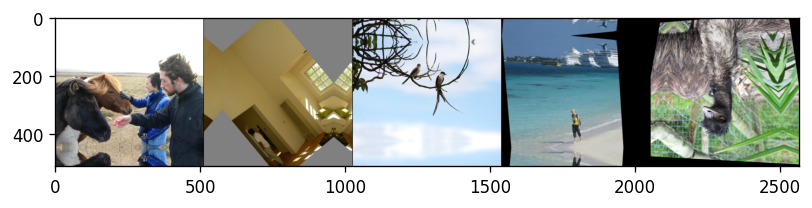

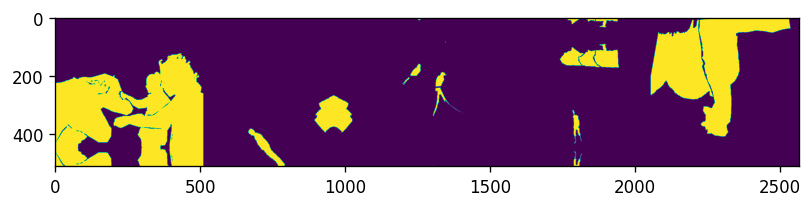

In [23]:
trainset_augmented = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                                multiclass=MULTICLASS, train=True, augment=True)
show_dataset(trainset_augmented)

чтобы каждая эпоха была на новых аугментированных данных, цикл поместим вне train_model и при этом будем каждый раз создавать новый датасет

In [24]:
NUM_EPOCH = 4

if TRAIN:
    valset.set_padding(unet.padding)
    for _ in range(NUM_EPOCH):
        trainset_augmented = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                                multiclass=MULTICLASS, train=True, augment=True)
    
        trainset_augmented.set_padding(unet.padding)
        train_model(unet, (DiceLoss, BCELoss), make_optimizer, trainset_augmented, valset,
                            lr_scheduler_fn=lambda optimizer: None,
                            eval_steps=500,
                            batch_size=4)
else:
    unet.load_state_dict(torch.load("checkpoint-aug.pth.tar", map_location=DEVICE))
    cvmade.plot.show_image("resources/01-1-aug.jpg")

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Show segmentation

In [25]:
def show_segmentations(model, dataset, n=5):
    model.eval()
    if USE_CUDA:
        model.cuda()
    for _ in range(n):
        image, mask_gt = dataset[random.randint(0, len(dataset) - 1)]
        if USE_CUDA:
            image = image.cuda()
            mask_gt = mask_gt.cuda()
        with torch.no_grad():
            predicted = model(image.unsqueeze(0))[0]  # CHW.
            predicted, image = crop_images(predicted.unsqueeze(0), image.unsqueeze(0))
            predicted, image = predicted[0], image[0]
            c = predicted.shape[0]
            if c == 1:
                predicted = torch.nn.functional.logsigmoid(predicted)
                aggregated = predicted[0]
                predicted_labels = predicted[0] > np.log(0.5)
            else:
                predicted = torch.nn.functional.log_softmax(predicted, 0)
                aggregated = torch.logsumexp(predicted[1:], axis=0)
                predicted_labels = predicted.max(0)[1]
        aggregated = aggregated.cpu().numpy()
        predicted_labels = predicted_labels.cpu().numpy().astype(np.uint8)
        image = cvmade.image.image_to_numpy(image)
        mask = (predicted_labels > 0)[..., None]
        selected = image * mask + 255 * (1 - mask)

        %matplotlib inline
        if c != 1:
            print("Classes:", [LABELS[i] for i in set(predicted_labels.flatten().tolist())])
        set_figure_size()
        fig, axs = plt.subplots(1, 4, figsize=(12, 6))
        axs[0].imshow(image)
        axs[1].imshow(predicted_labels)
        axs[2].imshow(aggregated)
        axs[3].imshow(selected)
        plt.show()

Trainset


<Figure size 960x720 with 0 Axes>

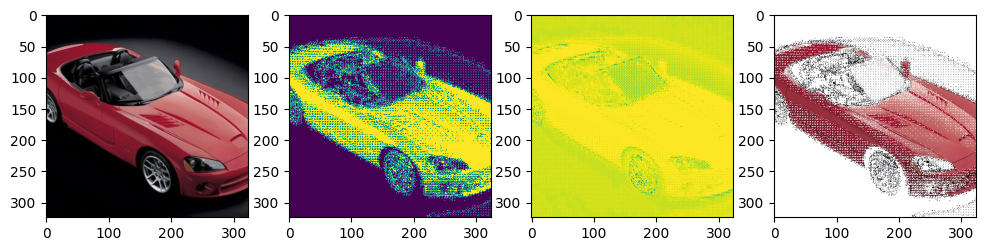

<Figure size 960x720 with 0 Axes>

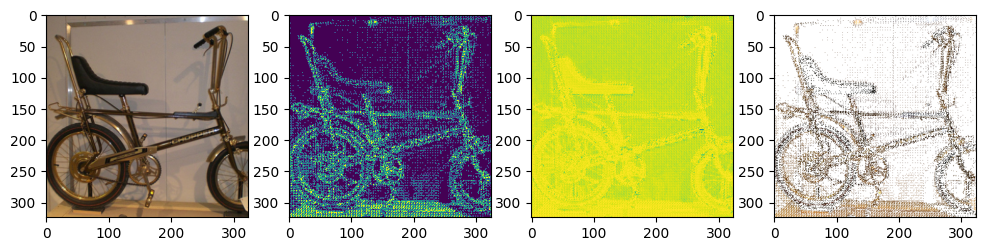

<Figure size 960x720 with 0 Axes>

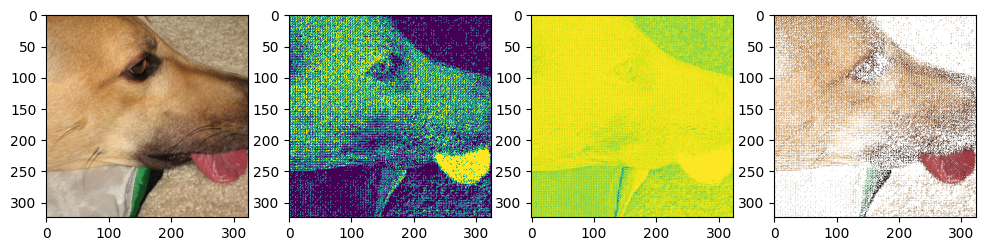

<Figure size 960x720 with 0 Axes>

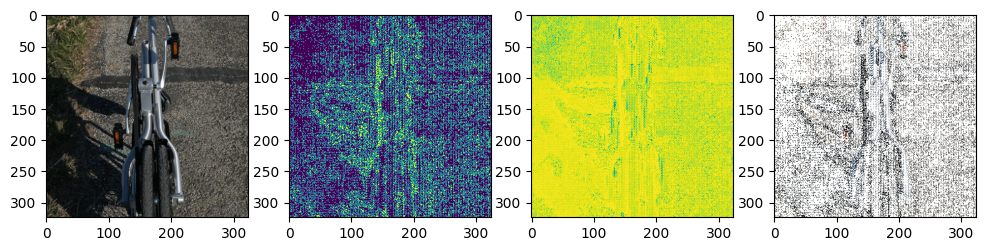

<Figure size 960x720 with 0 Axes>

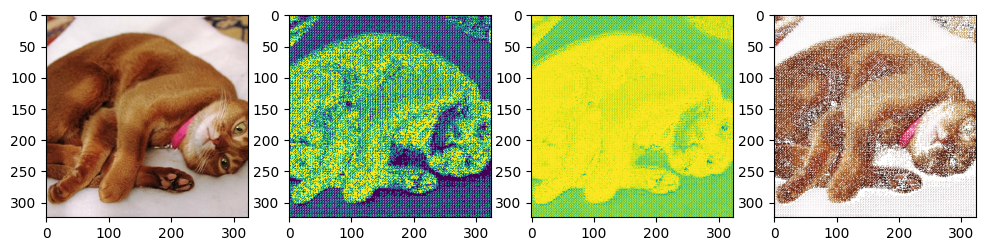

Valset


<Figure size 960x720 with 0 Axes>

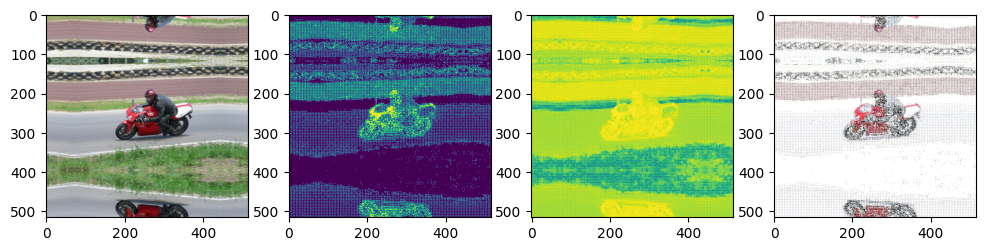

<Figure size 960x720 with 0 Axes>

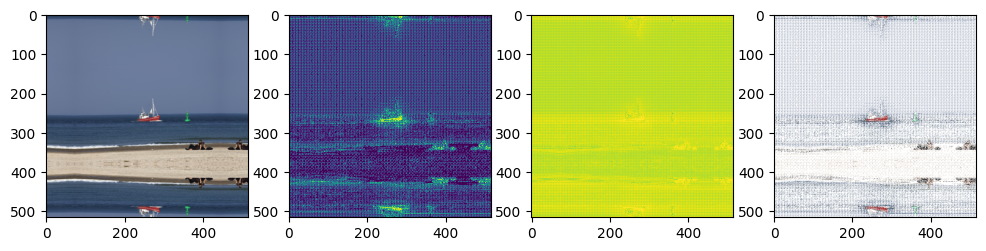

<Figure size 960x720 with 0 Axes>

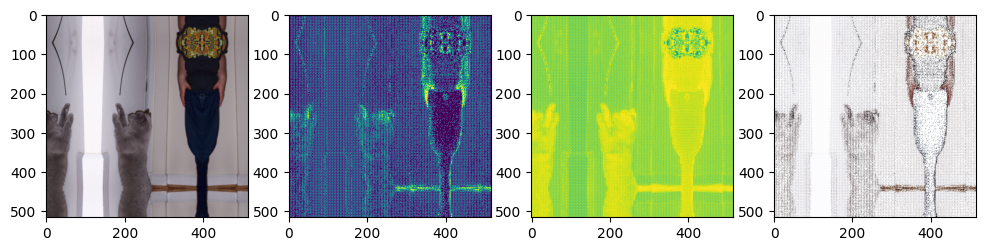

<Figure size 960x720 with 0 Axes>

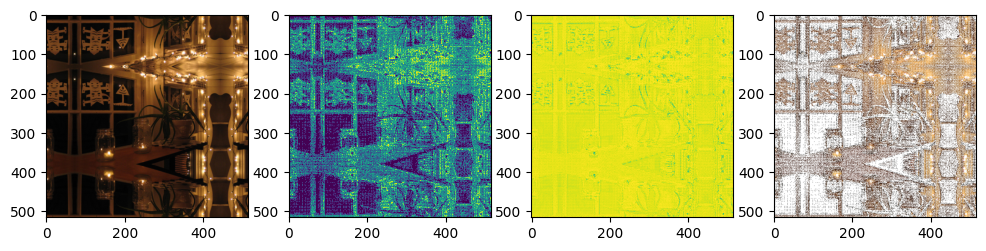

<Figure size 960x720 with 0 Axes>

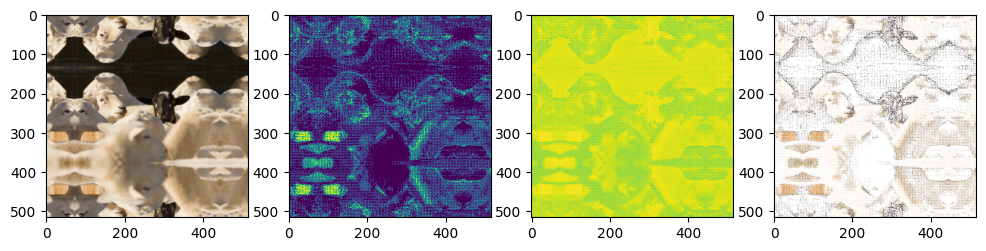

In [26]:
print("Trainset")
show_segmentations(unet, trainset)

print("Valset")
show_segmentations(unet, valset)

# Show losses and mean IoU

с помощью tensorboard можно посмотреть все графики лоссов, а также метрику mean IoU

но на Kaggle TensorBoard не работает(

In [52]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 323), started 0:21:45 ago. (Use '!kill 323' to kill it.)